# Neural Networks with Keras

In [ ]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Python >= 3.5 is required 
import sys
assert sys.version_info >= (3, 5)

#Scikit-Learn >= 0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Tensorflow >=2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import pandas as pd
import numpy as np
import os 

# Stabilizing outputs across multiple notebook runs
np.random.seed(42)

# Plotting libraries
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('xtick', labelsize=14)

# Un-comment if the figures of this notebook need to be saved

# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "ann"
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
# os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=480):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure ", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore inconsequential warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")


## Perceptrons

Implementing a single layer / single-TLU (threshold logic unit) Perceptron.

In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)] # petal length, petal width inside the parenthesis
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [4]:
y_pred

array([1])

In [5]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.coef_[0][0] / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1)
        )

X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

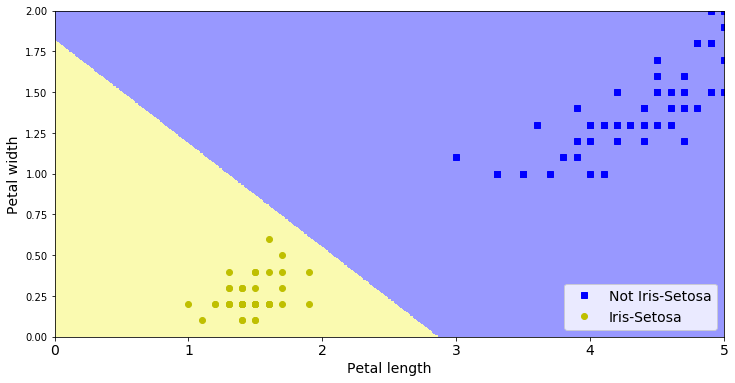

In [6]:
# Plotting the results of the above
from matplotlib.colors import ListedColormap

plt.figure(figsize=(12, 6))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show();

## Activation Functions

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps = 0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

Let's visualize these activation functions for better clarity...

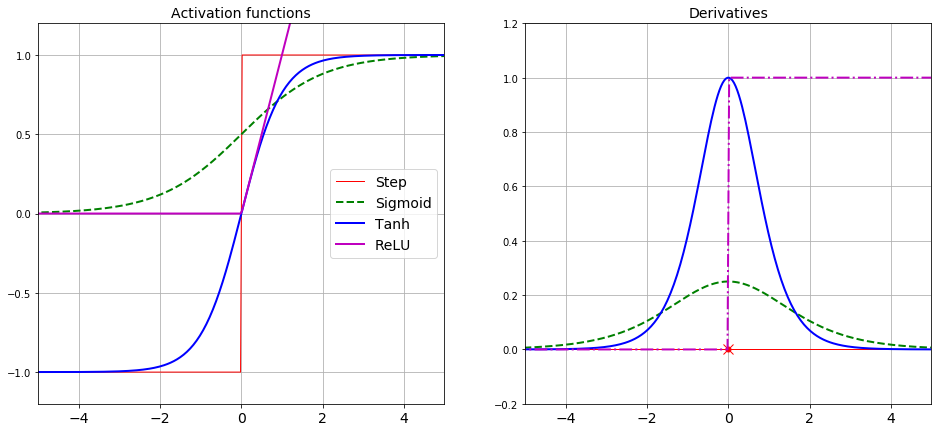

In [8]:
z = np.linspace(-10, 10, 500)

plt.figure(figsize = (16, 7))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show();

## Building an Image Classifier Using Tensorflow and Keras

In [9]:
import tensorflow as tf
from tensorflow import keras

Let's start by loading the fashion MNIST dataset. We'll be using Keras to load popular datasets in **keras.datasets**. As a reminder, the dataset has already been split between a training and a test set.

In [10]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [11]:
X_train_full.shape

(60000, 28, 28)

In [12]:
X_train_full.dtype

dtype('uint8')

Since we are going to train the NN using SGD, we must scale the input features. For simplicity, we'll scale the pixel intensities down to 0 - 1 and convert them to floats.

In [13]:
# Splitting into training and validation sets
# We shall scale the pixel intensities down to the 0-1 range and convert to floats
# by dividing by 255.
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255. 
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

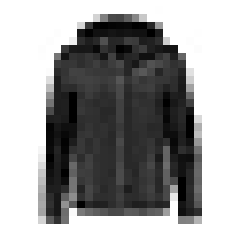

In [14]:
# Plotting using imshow() with a binary color map
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show();

In [15]:
# Checking training labels
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [16]:
# Adding the corresponding class names
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [17]:
# Verifying labels
class_names[y_train[0]], class_names[y_train[1]]

('Coat', 'T-shirt/top')

In [18]:
# Checking both the validation and the test sets
X_valid.shape, X_test.shape

((5000, 28, 28), (10000, 28, 28))

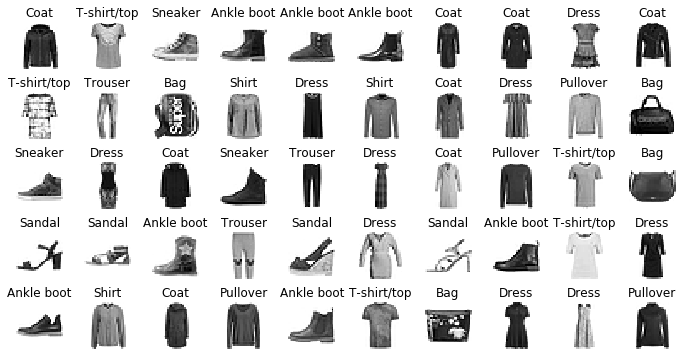

In [19]:
# Let's grab a sample of the images in the dataset
n_rows=5
n_cols=10

plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col # that's a really cool way to build an index!
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap='binary', interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()
    

## Model Creation Using Sequential API

In [20]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

**`Quick Notes on the Model`**
1. The first line creates a sequential model and is the simplest neural network i.e. a single stack of layers connected sequentially.
2. The first layer, or the Flatten layer, converts each input image into a 1D array. This layer does not have any parameters and exists solely for preprocessing. The first layer also accepts the **input_shape**, but doesn't include the batch size. Alternatively, we can add a **keras.layers.InputLayer** as the first layer.
3. The next hidden layer is called the **Dense Layer** with 300 neurons and used ReLU activation function. Each Dense layer manages its own weight matrix and also a vector of bias terms(one per neuron).
4. Then we add a second Dense hidden layer with 100 neurons (with ReLU activation) and finally a Dense output layer with 10 neurons (one per class), using the softmax activation funtion due to the exclusivity of the classes.

**Instead of adding layer upon layer, we can pass a list of layers when creating the Sequential Model.**

In [21]:
# Clearing session
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [22]:
# Re-creating the model, but this time as a list
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [23]:
# Verifying
model.layers

In [24]:
# Getting model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


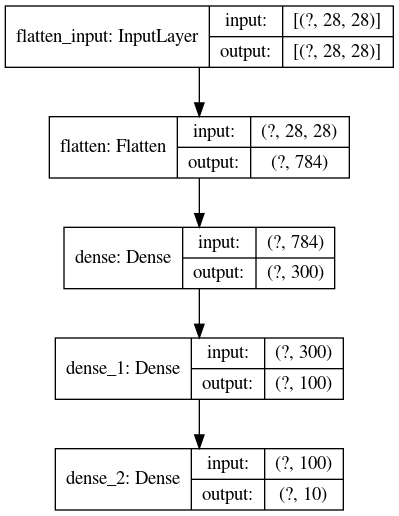

In [25]:
keras.utils.plot_model(model, to_file='fashion_mnist_model.png', show_shapes=True, 
                       show_layer_names=True)

In [26]:
# Checking layer names
hidden1 = model.layers[1]
hidden1.name

'dense'

In [27]:
# Additional layer details and checks
model.get_layer('dense') is hidden1

True

In [28]:
# All parameters of a layer can be accessed using the following
weights, biases = hidden1.get_weights()

In [29]:
weights, weights.shape

(array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
          0.03859074, -0.06889391],
        [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
         -0.02763776, -0.04165364],
        [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
          0.07121518, -0.07331658],
        ...,
        [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
          0.00228987,  0.05581069],
        [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
          0.00034875,  0.02878492],
        [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
          0.00272203, -0.06793761]], dtype=float32),
 (784, 300))

In [30]:
biases, biases.shape

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

The dense layer initializes the connection weights randomly, which is needed to be break symmetry. We can also used different initialization methods using **kernel_initializer** or **bias_initializer**. These will be covered in subsequent notebooks.

#### **Important Note**

The shape of the weight matrix depends on the number of inputs. This is why it is recommended to specify the input_shape when creating the first layer in a Sequential model. However, if you do not specify the input shape, it’s OK: Keras will simply wait until it knows the input shape before it actually builds the model. This will happen either when you feed it actual data (e.g., during training), or when you call its build() method. Until the model is really built, the layers will not have any weights, and you will not be able to do certain things (such as print the model summary or save the model). So, if you know the input shape when creating the model, it is best to specify it.

## Compiling the Model

In [31]:
# Compiling the model we just created
# Also it is important to note that by using optimizer='sgd', LR is defaulted to 0.01
# optimizer=keras.optimizers.SGD(lr=???) to set the LR manually.
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.015),
              metrics=["accuracy"])

_The equivalent code is:_

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
              
- `sparse_categorical_crossentropy` loss is used since we have sparse labels i.e. we only have a target class index, from 0 to 9, for each instance, and the classes are exclusive.
- If we had one target probability per class for each instance, then we would use `categorical_crossentropy` loss instead.
- For binary classifications (with one or more binary labels) we would use the `sigmoid` activation function in the output layer instead of `softmax`, by calling `binary_crossentropy`.

In [32]:
# Fitting the model
history = model.fit(X_train, y_train, epochs=30,
                   validation_data = (X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 2s 45us/sample - loss: 0.6632 - accuracy: 0.7775 - val_loss: 0.5086 - val_accuracy: 0.8202
Epoch 2/30
55000/55000 [==============================] - 2s 40us/sample - loss: 0.4615 - accuracy: 0.8383 - val_loss: 0.4303 - val_accuracy: 0.8518
Epoch 3/30
55000/55000 [==============================] - 2s 44us/sample - loss: 0.4159 - accuracy: 0.8535 - val_loss: 0.3947 - val_accuracy: 0.8642
Epoch 4/30
55000/55000 [==============================] - 2s 38us/sample - loss: 0.3895 - accuracy: 0.8621 - val_loss: 0.3694 - val_accuracy: 0.8728
Epoch 5/30
55000/55000 [==============================] - 2s 39us/sample - loss: 0.3688 - accuracy: 0.8687 - val_loss: 0.3711 - val_accuracy: 0.8682
Epoch 6/30
55000/55000 [==============================] - 2s 39us/sample - loss: 0.3524 - accuracy: 0.8741 - val_loss: 0.3496 - val_accuracy: 0.8820
Epoch 7/30
55000/55000 [==============================] -

In [33]:
# Let's check our training parameters
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

** The fit() method returns a History object containing the training parameters `history.params` alongside `history.epoch` and a dictionary `history.history` containing the loss and extra metrics it measured for the training set and the validation set. This dictionary will be used to plot our learning curves.

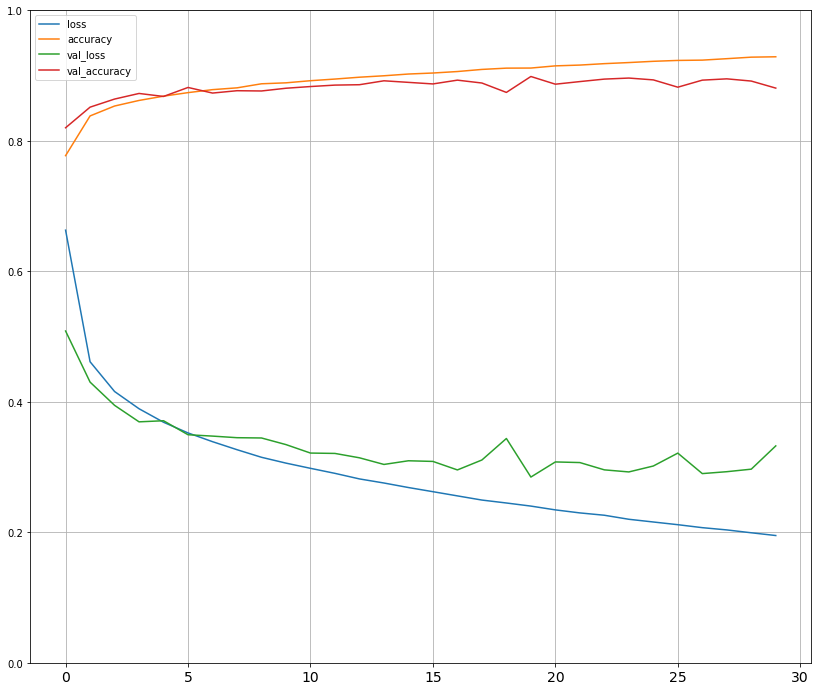

In [34]:
# Plotting our learning curves
pd.DataFrame(history.history).plot(figsize=(14,12))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [35]:
# Evaluating our model
#model.evaluate(X_test, y_test)

## Uncomment and run later since this is an ongoing issue.

### Making Predictions

In [36]:
# Making predictions on 10 new instances.
X_new = X_test[:10]

y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.26, 0.  , 0.01, 0.  , 0.  , 0.  , 0.73, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ]],
      dtype=float32)

In [37]:
# Instead of looking at predictions made on every possible class,we can 
# print the highest probability class for each new instance
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [38]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser',
       'Coat', 'Shirt', 'Sandal', 'Sneaker'], dtype='<U11')

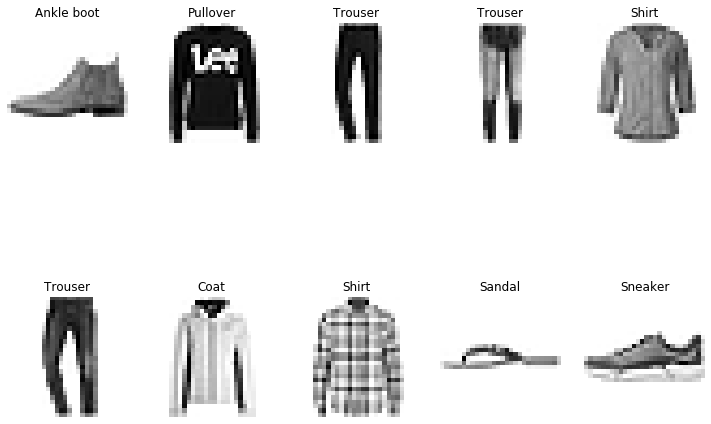

In [39]:
# Plotting the predicted labels
plt.figure(figsize=(12.5, 8.4))
for index, image in enumerate(X_new):
    plt.subplot(2, 5, index + 1)
    plt.imshow(image, cmap='binary', interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Building a Regression MLP Using the Sequential API

In [40]:
# Clearing session
keras.backend.clear_session()

In [41]:
# Loading the California housing problem dataset for our regression neural net.
from sklearn.datasets import california_housing, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing() 

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

/home/bilal/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.california_housing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


**`Note:`** Setting the random state during splitting of the datasets has extremely detrimental effects on the loss of the NN for the validation set. Interesting case for futher investigation.

We will apply a similar approach to building, training and evaluating as before. The main differences are:

1. The output layer has a single neuron to predict a single value.
2. No activation function is used.
3. The loss function is MSE.

Since the dataset is noisy, we will use a single hidden layer with fewer neurons to avoid over-fitting.

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

In [43]:
model = keras.models.Sequential([
    keras.layers.Dense(40, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error",
              optimzer=keras.optimizers.SGD(lr=1e-3))

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test, verbose=0) # again, issues!

X_new = X_test[:10]
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 51us/sample - loss: 0.9468 - val_loss: 0.5993
Epoch 2/20
11610/11610 [==============================] - 0s 27us/sample - loss: 0.5250 - val_loss: 0.5230
Epoch 3/20
11610/11610 [==============================] - 0s 27us/sample - loss: 0.5995 - val_loss: 0.5209
Epoch 4/20
11610/11610 [==============================] - 0s 38us/sample - loss: 0.5678 - val_loss: 0.5112
Epoch 5/20
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5376 - val_loss: 0.4927
Epoch 6/20
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4909 - val_loss: 0.4636
Epoch 7/20
11610/11610 [==============================] - 0s 30us/sample - loss: 0.4391 - val_loss: 0.4275
Epoch 8/20
11610/11610 [==============================] - 0s 29us/sample - loss: 0.4116 - val_loss: 0.4108
Epoch 9/20
11610/11610 [==============================] - 0s 28us/sample - loss: 0.3719 - val_l

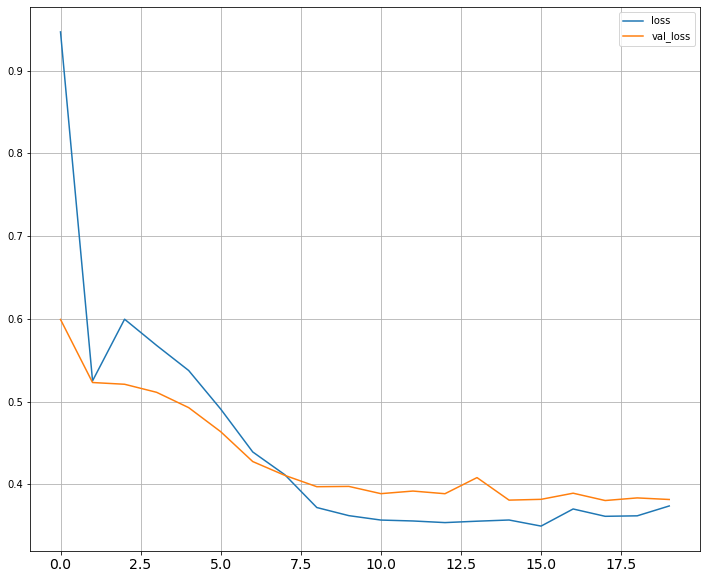

In [44]:
pd.DataFrame(history.history).plot(figsize=(12, 10))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.show()

In [45]:
y_pred

array([[0.549896 ],
       [1.6493323],
       [3.9395978],
       [2.5598361],
       [2.9096668],
       [1.7126937],
       [2.570868 ],
       [1.4783388],
       [2.7310832],
       [4.071175 ]], dtype=float32)

## Building Complex Models Using the Functional API

We will be building a _Wide and Deep_ neural network as an example of a non sequential NNs. The architecture of this network was first introduced in a [2016 research paper](https://arxiv.org/abs/1606.07792) by Heng-Tze Cheng et al. In short, this architecture allows the neural network to learn both deep patterns and simple rules, through a combination of deep and short paths.

The Functional API is used for complex topologies.

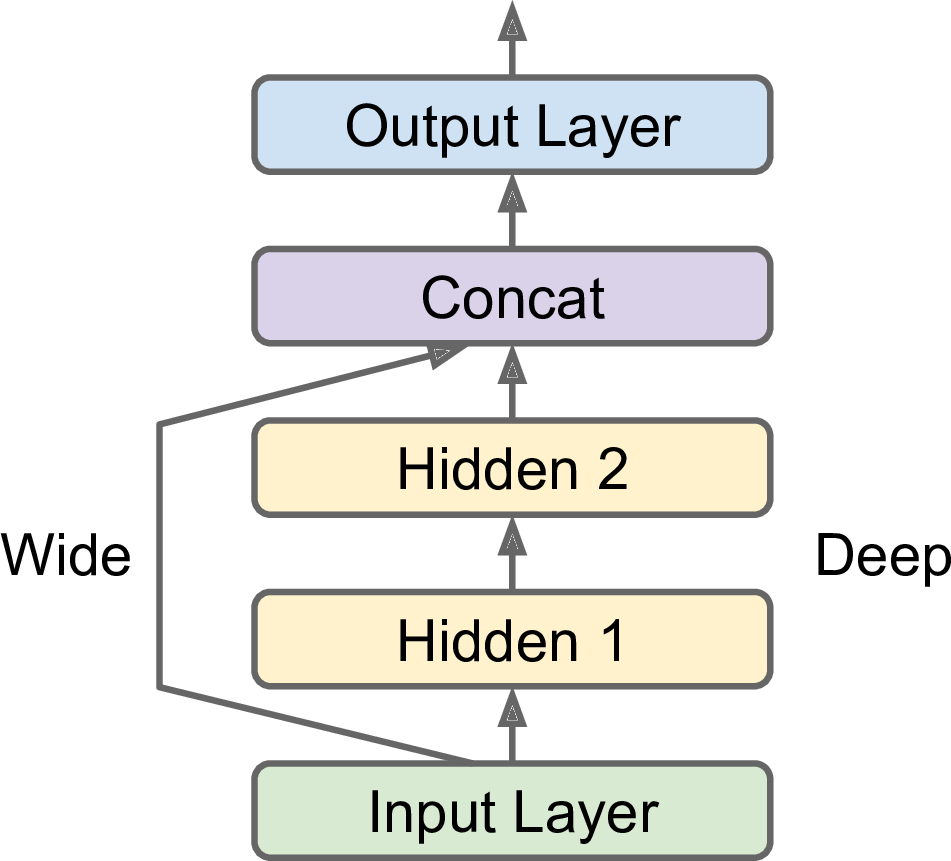

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

In [47]:
# Creating our model using the Functional API
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(40, activation="relu")(input_) # Passing the previoud layer
hidden2 = keras.layers.Dense(40, activation="relu")(hidden1)# for Keras to connect them.
concat = keras.layers.concatenate([input_, hidden2]) # concat the input and output layers
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 40)           360         input_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 40)           1640        dense_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 48)           0           input_1[0][0]                    
                                                                 dense_3[0][0]                

In [49]:
# Compiling, training and evaluating the model
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))

history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))
#mse_test = model.evaluate(X_test, y_test) # evaluate still has issues
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 52us/sample - loss: 1.7181 - val_loss: 0.8115
Epoch 2/30
11610/11610 [==============================] - 0s 31us/sample - loss: 0.7333 - val_loss: 0.6629
Epoch 3/30
11610/11610 [==============================] - 0s 32us/sample - loss: 0.6169 - val_loss: 0.6200
Epoch 4/30
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5858 - val_loss: 0.5986
Epoch 5/30
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5657 - val_loss: 0.5812
Epoch 6/30
11610/11610 [==============================] - 0s 29us/sample - loss: 0.5502 - val_loss: 0.5677
Epoch 7/30
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5377 - val_loss: 0.5547
Epoch 8/30
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5271 - val_loss: 0.5463
Epoch 9/30
11610/11610 [==============================] - 0s 28us/sample - loss: 0.5187 - val_l

### Sending Subsets of Data

What if we want to send a subset of features through the wide path and another one through the deep path. One solution is to use multiple inputs:

In [50]:
keras.backend.clear_session()

In [51]:
# Subset methodology 1
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [52]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                     validation_data=((X_valid_A, X_valid_B), y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 50us/sample - loss: 1.7504 - val_loss: 0.8357
Epoch 2/20
11610/11610 [==============================] - 0s 31us/sample - loss: 0.7690 - val_loss: 0.7082
Epoch 3/20
11610/11610 [==============================] - 0s 34us/sample - loss: 0.6766 - val_loss: 0.6536
Epoch 4/20
11610/11610 [==============================] - 0s 35us/sample - loss: 0.6292 - val_loss: 0.6204
Epoch 5/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5969 - val_loss: 0.5956
Epoch 6/20
11610/11610 [==============================] - 0s 31us/sample - loss: 0.5730 - val_loss: 0.5759
Epoch 7/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5550 - val_loss: 0.5609
Epoch 8/20
11610/11610 [==============================] - 0s 32us/sample - loss: 0.5406 - val_loss: 0.5489
Epoch 9/20
11610/11610 [==============================] - 0s 30us/sample - loss: 0.5292 - val_l

In [53]:
# Evaluating
#mse_test = model.evaluate((X_test_A, X_test_B), y_test) # uncomment once evaluate is fixed

In [54]:
y_pred = model.predict((X_new_A, X_new_B))

**`NOTE`** There can be a variety of reasons for having multiple outputs:
1. Locating and classifying the main object in a picture. This is both a regression task and a classification task.
2. Neural networks can learn features that can be useful across tasks. For e.g. performing a multitask classification on pictures of faces, where one output classifies a person's facial expression and the other to identify whether they are wearing glasses or not.
3. As a regularization technique. For e.g. auxiliary outputs in a neural network architecture to ensure that the underlying part of the network learns something useful on its own.

### Adding Auxiliary Outputs

In [55]:
keras.backend.clear_session()

In [56]:
# Aux outputs can be connected to the appropriate layers
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)

model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [57]:
# Making the necessary changes to compile()
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1],
              optimizer=keras.optimizers.SGD(lr=1e-3))

In [58]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 60us/sample - loss: 2.7370 - main_output_loss: 2.2638 - aux_output_loss: 6.9871 - val_loss: 1.5149 - val_main_output_loss: 1.0562 - val_aux_output_loss: 5.6419
Epoch 2/20
11610/11610 [==============================] - 1s 47us/sample - loss: 1.1944 - main_output_loss: 0.8527 - aux_output_loss: 4.2687 - val_loss: 0.9973 - val_main_output_loss: 0.7526 - val_aux_output_loss: 3.1985
Epoch 3/20
11610/11610 [==============================] - 1s 47us/sample - loss: 0.8904 - main_output_loss: 0.7079 - aux_output_loss: 2.5302 - val_loss: 0.8153 - val_main_output_loss: 0.6725 - val_aux_output_loss: 2.0994
Epoch 4/20
11610/11610 [==============================] - 0s 41us/sample - loss: 0.7629 - main_output_loss: 0.6493 - aux_output_loss: 1.7846 - val_loss: 0.7305 - val_main_output_loss: 0.6286 - val_aux_output_loss: 1.6463
Epoch 5/20
11610/11610 [==============================] - 0s 39us/s

In [59]:
# Getting total loss and individual losses and predictions
#total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

## The Sub-Classing API

This API is used when we want to make our models dynamic for e.g. looping, varying shapes, conditional branching etc.

In [60]:
class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

In [61]:
model = WideAndDeepModel(30, activation="relu")

In [62]:
# Compiling, training and evaluating
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))

history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=20,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))

#total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 66us/sample - loss: 2.6978 - output_1_loss: 2.4018 - output_2_loss: 5.3516 - val_loss: 1.3520 - val_output_1_loss: 0.9690 - val_output_2_loss: 4.7980
Epoch 2/20
11610/11610 [==============================] - 1s 54us/sample - loss: 1.1147 - output_1_loss: 0.8071 - output_2_loss: 3.8813 - val_loss: 0.9481 - val_output_1_loss: 0.7041 - val_output_2_loss: 3.1427
Epoch 3/20
11610/11610 [==============================] - 1s 52us/sample - loss: 0.8784 - output_1_loss: 0.6763 - output_2_loss: 2.6958 - val_loss: 0.8169 - val_output_1_loss: 0.6529 - val_output_2_loss: 2.2914
Epoch 4/20
11610/11610 [==============================] - 1s 61us/sample - loss: 0.7809 - output_1_loss: 0.6327 - output_2_loss: 2.1137 - val_loss: 0.7508 - val_output_1_loss: 0.6227 - val_output_2_loss: 1.9018
Epoch 5/20
11610/11610 [==============================] - 1s 55us/sample - loss: 0.7265 - output_1_loss: 0.

## Saving and Loading the Model

In [63]:
model.save("multiout_model")

# We can save the functional and the sequential API models as a HDF5 by adding .h5 after the model name.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: multiout_model/assets


In [64]:
model = keras.models.load_model("multiout_model")

In [65]:
model.save_weights("my_keras_weights.ckpt")

In [66]:
model.load_weights("my_keras_weights.ckpt")

In [67]:
model.predict((X_new_A, X_new_B))

[array([[0.4559325],
        [1.8819824],
        [2.7384253]], dtype=float32),
 array([[1.2594601],
        [1.5065451],
        [1.9771914]], dtype=float32)]

## Using Callbacks.

The fit() method accepts _callbacks_ argument that lets us specify a list of objects that Keras will call at the start and end of training, epochs and even before and after batch processing.

In [68]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [69]:
# Rebuilding out sequential model.
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [70]:
# Incorporating a checkpoint callback
# save_best_only=True will save the model when its performance on the validation set
# is the best. This is a simple method of introducting early stopping.
check_cb = keras.callbacks.ModelCheckpoint("this_keras_model", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[check_cb])

model = keras.models.load_model("this_keras_model") #rollback to best model
#mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 76us/sample - loss: 1.9289 - val_loss: 0.7753
Epoch 2/10
11610/11610 [==============================] - 1s 49us/sample - loss: 0.6834 - val_loss: 0.6422
Epoch 3/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.6129 - val_loss: 0.6007
Epoch 4/10
11610/11610 [==============================] - 1s 47us/sample - loss: 0.5763 - val_loss: 0.5717
Epoch 5/10
11610/11610 [==============================] - 1s 57us/sample - loss: 0.5488 - val_loss: 0.5493
Epoch 6/10
11610/11610 [==============================] - 1s 51us/sample - loss: 0.5272 - val_loss: 0.5313
Epoch 7/10
11610/11610 [==============================] - 1s 51us/sample - loss: 0.5103 - val_loss: 0.5156
Epoch 8/10
11610/11610 [==============================] - 1s 48us/sample - loss: 0.4965 - val_loss: 0.5050
Epoch 9/10
11610/11610 [==============================] - 1s 53us/sample - loss: 0.4860 - val_l

In [71]:
# We can implement early stopping by using the EarlyStopping callback
# This interrupts training when it measures no progress on the validation set for
# a few epochs.
# Both callbacks can be used to save checkpoints of the model and interrrupt training early.
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_valid, y_valid),
                    callbacks=[check_cb, early_stopping_cb])
#mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 69us/sample - loss: 0.4701 - val_loss: 0.4830
Epoch 2/100
11610/11610 [==============================] - 0s 41us/sample - loss: 0.4644 - val_loss: 0.4787
Epoch 3/100
11610/11610 [==============================] - 1s 56us/sample - loss: 0.4601 - val_loss: 0.4735
Epoch 4/100
11610/11610 [==============================] - 0s 41us/sample - loss: 0.4556 - val_loss: 0.4707
Epoch 5/100
11610/11610 [==============================] - 0s 41us/sample - loss: 0.4522 - val_loss: 0.4675
Epoch 6/100
11610/11610 [==============================] - 1s 44us/sample - loss: 0.4488 - val_loss: 0.4653
Epoch 7/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4462 - val_loss: 0.4615
Epoch 8/100
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4434 - val_loss: 0.4596
Epoch 9/100
11610/11610 [==============================] - 0s 42us/sample - loss: 0.441

In [72]:
# Writing our own custom callbacks for greater control.
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [73]:
val_train_ratio_cb = PrintValTrainRatioCallback()

history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
11488/11610 [============================>.] - ETA: 0s - loss: 0.3494
val/train: 1.08
11610/11610 [==============================] - 0s 29us/sample - loss: 0.3505 - val_loss: 0.3794


## Tensorboard for Visualizations

In order to use Tensorboard, which comes pre-packaged with TensorFlow, we must modify our script so that it outputs the data we want to visualize to _event files_, which are special binary log files.

In [74]:
# Setting output path
root_logdir = os.path.join(os.curdir, "my_logs")

In [75]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2020_06_04-11_19_12'

Keras has a built in Tensorboard() callback.

In [76]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [77]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimzer=keras.optimizers.SGD(lr=1e-3))

In [78]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [79]:
history = model.fit(X_train, y_train, epochs=40,
                    validation_data=(X_valid, y_valid),
                    callbacks=[check_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/40
11610/11610 [==============================] - 1s 57us/sample - loss: 1.0363 - val_loss: 0.5060
Epoch 2/40
11610/11610 [==============================] - 0s 34us/sample - loss: 0.5055 - val_loss: 0.4819
Epoch 3/40
11610/11610 [==============================] - 0s 36us/sample - loss: 0.5460 - val_loss: 0.4546
Epoch 4/40
11610/11610 [==============================] - 0s 29us/sample - loss: 0.4522 - val_loss: 0.4227
Epoch 5/40
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4083 - val_loss: 0.4103
Epoch 6/40
11610/11610 [==============================] - 1s 55us/sample - loss: 0.3605 - val_loss: 0.3738
Epoch 7/40
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3331 - val_loss: 0.3614
Epoch 8/40
11610/11610 [==============================] - 1s 65us/sample - loss: 0.3268 - val_loss: 0.3523
Epoch 9/40
11610/11610 [==============================] - 1s 50us/sample - loss: 0.3189 - val_l

**`NOTE`**

One way of starting the Tensorboard server is by running the following command in a terminal:

$ tensorboard --logdir=./my_logs --port=6006

If the shell cannot find the tensorboard script then the PATH environment variable must be updated so that it contains the directory in which the script was installed.

We can also replace `tensorboard` in the command line with `python3 -m tensorboard.main`. Once the server is running, opena browser window which goes to `http://localhost:6006`.

Finally, tensorboard can also be directly launched in the Jupyter notebook, as the code below demonstrates.

In [81]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 19669), started 0:08:47 ago. (Use '!kill 19669' to kill it.)

#### TensorFlow Lower-Level API

In [82]:
test_log_dir = get_run_logdir()

# The tf.summary package contains the lower-level API
writer = tf.summary.create_file_writer(test_log_dir)

In [84]:
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scaler", np.sin(step / 10), step=step)
        # Generating random data
        data = (np.random.randn(100) + 2) * step / 100
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        # Random 32x32 RGB images
        images = np.random.rand(2, 32, 32, 3)
        tf.summary.image("my_images", images * step / 1000, step=step)
        # Random text
        texts = ["The step is " + str(step), "Its square is " + str(step**2)]
        tf.summary.text("my_text",texts, step=step)
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi *step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

## Fine Tuning Neural Network Hyper-Parameters

In [85]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

One of the most basic methods of fine-tuning involves the use of _GridSearchCV_ or _RandomizedSearchCV_ to explore the hyperparameter space. In order  for this to work, the Keras models need to be wrapped in objects that mimic regular SK-Learn regressors.

In [86]:
# Creating function to build and compile a Keras model
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [87]:
# Creating Keras regressor which can then be used as a
# regular Scikit-Learn regressor
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [88]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 0s 41us/sample - loss: 1.2171 - val_loss: 0.7352
Epoch 2/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.7088 - val_loss: 0.5860
Epoch 3/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.5469 - val_loss: 0.5407
Epoch 4/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.5106 - val_loss: 0.5132
Epoch 5/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4869 - val_loss: 0.4964
Epoch 6/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.4712 - val_loss: 0.4848
Epoch 7/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.4606 - val_loss: 0.4735
Epoch 8/100
11610/11610 [==============================] - 0s 26us/sample - loss: 0.4524 - val_loss: 0.4686
Epoch 9/100
11610/11610 [==============================] - 0s 27us/sample - loss: 0.446

In [91]:
#mse_test = keras_reg.score(X_test, y_test)

In [92]:
y_pred = keras_reg.predict(X_new)

In [93]:
y_pred

array([0.4071941, 1.5482154, 3.7888856, 2.688416 , 2.8403342, 1.6875823,
       2.7197702, 1.6840934, 2.768636 , 4.255766 ], dtype=float32)

When attempting to train and evaluate numerous models, all with their various hyper-parameters it is preferable to use a _randomized_ search instead of a _grid_ search.

In [94]:
np.random.seed(42)
tf.random.set_seed(42)

In [97]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])



'\nfrom scipy.stats import reciprocal\nfrom sklearn.model_selection import RandomizedSearchCV\n\nparam_distribs = {\n    "n_hidden": [0, 1, 2, 3],\n    "n_neurons": np.arange(1, 100),\n    "learning_rate": reciprocal(3e-4, 3e-2),\n}\n\nrnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)\nrnd_search_cv.fit(X_train, y_train, epochs=100,\n                  validation_data=(X_valid, y_valid),\n                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])\n'